# Efficient Net vs Dino for Skin Cancer Detection

## Imports

In [ ]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import timm

from PIL import Image

from huggingface_hub import PyTorchModelHubMixin

import h5py

import os
import polars as pl
import io

# Versions

In [48]:
!python --version

Python 3.12.12


In [47]:
# Check dependency versions
import sklearn
import huggingface_hub
import safetensors
import matplotlib

import PIL

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"Numpy Version: {np.__version__}")

print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"Seaborn Version: {sns.__version__}")

print(f"Sklearn Version: {sklearn.__version__}")
print(f"Timm Version: {timm.__version__}")

print(f"PIL Version: {PIL.__version__}")

print(f"Hugging Face Hub Version: {huggingface_hub.__version__}")

print(f"h5py Version: {h5py.__version__}")

print(f"Polars Version: {pl.__version__}")

print(f"Safetensors Version: {safetensors.__version__}")

PyTorch Version: 2.9.0+cu126
Torchvision Version: 0.24.0+cu126
Numpy Version: 2.0.2
Matplotlib Version: 3.10.0
Seaborn Version: 0.13.2
Sklearn Version: 1.6.1
Timm Version: 1.0.22
PIL Version: 11.3.0
Hugging Face Hub Version: 0.36.0
h5py Version: 3.15.1
Polars Version: 1.31.0
Safetensors Version: 0.7.0


## Set Up Device

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
elif torch.backends.mps.is_available(): # For Apple Silicon
  device = torch.device("mps")
else:
  device = torch.device("cpu")


print(device)

cuda


## Important Functions

### Weighted Loss Function

In [ ]:
def weighted_bce_loss(logits, labels, is_real):
  """
  Assumes logits are already passed through sigmoid and labels is a float.

  All tensors must be on the same device.
  """
  # labels: 0/1
  # is_real: 1 if positive is real, 0 if synthetic or negative

  # base weight 1.0
  weights = torch.ones_like(labels).to(device)

  # real positives -> strong weight
  weights[(labels == 1) & (is_real == 1)] = 400

  # synthetic positives -> small weight (don't want model to think synthetics are the only positives)
  weights[(labels == 1) & (is_real == 0)] = 2.0

  # negatives remain 1.0

  return torch.nn.functional.binary_cross_entropy_with_logits(
      logits, labels, weight=weights
  )

### pAUC calculation

In [ ]:
def calculate_pauc(y_test_pred: np.ndarray, y_test_target: np.ndarray, min_tpr: float = 0.80) -> float:
    """
     Args:
        y_test_pred: predictions, each one in range [0, 1]
        y_test_target: ground truth array of 0s and 1s
        min_tpr: Minimum true positive rate
    See: https://www.kaggle.com/code/metric/isic-pauc-abovetpr/notebook

    Note: The predictions should be the probability that the given image is benign or maligant. So, it should be
          extremely unlikely for any prediction to be 0 or 1.
    """

    v_gt = np.abs(1 - y_test_target)
    v_pred = 1 - y_test_pred

    max_fpr = abs(1 - min_tpr) # Max false positive rate

    # Returns standardized partial AUC over the range [0, max_fpr]
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)


    # Change scale from [0.5, 1.0] to [0.5 * (max_fpr ** 2), max_fpr]
    # Using formula f(t) = c + ((d - c)/(b-a))(t-a), where f maps [a,b] onto [c,d]
    # See https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range for more info
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr **2) / 0.5 * (partial_auc_scaled - 0.5)

    return partial_auc


### Create Confusion Matrix

In [ ]:
def _create_confusion_matrix(y, y_hat, title) -> None:
  cm = confusion_matrix(y, y_hat)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
  disp.plot(xticks_rotation='vertical', cmap='Blues')
  plt.title(title)
  plt.show()

## Get Data

### Real Images

In [ ]:
# Unzip everything locally (speed boost)
!unzip /content/data/isic-2024-challenge.zip -d /content/data/
!unzip /content/data/isic-2024-synthetic.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/isic-2024-synthetic/images/ab074f56-0598-4db3-9954-6401caf02c7d___1.png  
  inflating: /content/data/isic-2024-synthetic/images/ab0b3aae-fbdc-40ab-b46c-9aec0136aae5___1.png  
  inflating: /content/data/isic-2024-synthetic/images/ab1681dd-9b65-414d-a7c8-b05277c6fc49___1.png  
  inflating: /content/data/isic-2024-synthetic/images/ab1bd389-cd66-44a9-97ba-b2fae3b841c7___1.png  
  inflating: /content/data/isic-2024-synthetic/images/ab1d451e-3427-404d-bfc6-886a67e29cdc___1.png  
  inflating: /content/data/isic-2024-synthetic/images/ab2556f0-0479-4f52-a9a9-2bb8fdd6642f___1.png  
  inflating: /content/data/isic-2024-synthetic/images/ab26a29b-f2fa-4841-b063-d72c511b4b0c___1.png  
  inflating: /content/data/isic-2024-synthetic/images/ab28f4fa-2fff-4d53-8ee1-52f09a886a2c___1.png  
  inflating: /content/data/isic-2024-synthetic/images/ab2f17d9-8ebd-41de-9972-68316872d363___1.png  
  inflating: /content/data/isic-2024-syn

In [ ]:
class RealImagesDataset(Dataset):
  """
  This dataset only contains 393 malignant examples, but it contains 400,666 benign examples.

  Total dataset size is 401,059
  """
  def __init__(self, hdf5_file, metadata, transform=None):
    super(RealImagesDataset, self).__init__() # Corrected class name

    # Load HDF5 file
    if not os.path.exists(hdf5_file):
      raise FileNotFoundError(f"The HDF5 file {hdf5_file} does not exist.") # Corrected f-string variable
    self.h5_file = h5py.File(hdf5_file, 'r')
    self.transform = transform

    # Load metadata w/ polars
    self.metadata = pl.read_csv(metadata)

    self.image_ids = list(self.h5_file.keys())

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    """
    The images are stored as raw bytes (compressed JPEG). Pil can open these, so that solves a lot.

    Also, the keys of the HDF5 file (self.image_ids) are the list of strings of isic_ids. In other words,
    the keys of the HDF5 file are the columm "isic_id" in the metadata. Both are all caps with underscore,
    so no modifications needed to index.
    """

    # Get image id for index
    image_id = self.image_ids[idx]

    # Retrieve the image data from the HDF5 file
    # The dataset is accessed via its key (the image_id)
    image_data_bytes = self.h5_file[image_id][()]


    # Use io.BytesIO to treat the bytes as a file and open with Pillow
    image = Image.open(io.BytesIO(image_data_bytes))
    # Convert image to RGB to ensure consistency (e.g., for paletted or grayscale images)
    image = image.convert('RGB')

    # Apply transformations if any
    if self.transform:
      image = self.transform(image)

    label = self.metadata.filter(pl.col("isic_id") == image_id).select("target").item()


    # Convert label to a tensor
    label = torch.tensor(label, dtype=torch.int16)

    # Return if real for weighting
    is_real = torch.tensor(1, dtype=torch.int16)

    return image, label, is_real

  def __del__(self):
    self.h5_file.close()

In [ ]:
hdf_train = "/content/data/train-image.hdf5"
hdf_metadata = "/content/data/train-metadata.csv"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Image net mean and std
    transforms.Resize((224, 224)),  # Dimensions for Efficient Net v2
])

real_images_dataset = RealImagesDataset(hdf_train, hdf_metadata, transform)

### Synthetic Images

In [ ]:
class SyntheticImagesDataset(Dataset):
  def __init__(self, dir_path, transform=None):
    super(SyntheticImagesDataset, self).__init__()
    self.dir_path = dir_path
    self.transform = transform

    self.image_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):

    image = Image.open(self.image_files[idx]).convert('RGB')

    if self.transform: # Apply transform if it exists
      image = self.transform(image)

    # All images are malignant
    label = torch.tensor(1, dtype=torch.int16)

    is_real = torch.tensor(0, dtype=torch.int16)

    return image, label, is_real


In [ ]:
syn_train = "/content/data/isic-2024-synthetic/images"

synthetic_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Dimensions for Efficient Net v2
])

synthetic_images_dataset = SyntheticImagesDataset(syn_train, synthetic_transforms)

### Data Loaders

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(real_images_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

train_dataset = torch.utils.data.ConcatDataset([train_dataset, synthetic_images_dataset])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Model Definitions

### Efficient Net v2-M

In [ ]:
class EfficientNetSkinLesionClassifier(nn.Module, PyTorchModelHubMixin):
  """
  PytorchModelHubMixin adds push to Hugging Face Hub

  See: https://huggingface.co/docs/hub/models-uploading#upload-a-pytorch-model-using-huggingfacehub
  """
  def __init__(self, num_classes=1):
    super(EfficientNetSkinLesionClassifier, self).__init__()

    # Step 1: Initialize backbone with the best available weights
    base_weights = EfficientNet_V2_M_Weights.DEFAULT
    self.backbone = efficientnet_v2_m(weights=base_weights)

    # Freeze entire backbone
    for param in self.backbone.parameters():
        param.requires_grad = False

    # Unfreeze ONLY the last block (low level feature detection is fine)
    for param in self.backbone.features[-1].parameters():
        param.requires_grad = True

    # Step 3: Replace the original classification head with a new one
    # The original classifier is called self.backbone.classifier
    # See: https://docs.pytorch.org/vision/main/_modules/torchvision/models/efficientnet.html#EfficientNet_V2_M_Weights

    feat_dim = self.backbone.classifier[1].in_features # Access the in_features of the final Linear layer

    # Same classifier format as original
    # Just switiching from ImageNet 1k classes to our binary classification
    # Dropout is 0.3 in pytorch implementation
    self.backbone.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(feat_dim, num_classes)
    )

  def forward(self, x):
    out = self.backbone(x)

    return out

### Dino V3

In [ ]:
class DinoSkinLesionClassifier(nn.Module):
  def __init__(self, num_classes=1, freeze_backbone=True):
    super(DinoSkinLesionClassifier, self).__init__()

    # Initialize Dino v3 backbone
    self.backbone = timm.create_model('vit_base_patch16_dinov3', pretrained=True, num_classes=0, global_pool='avg')

    # Freeze backbone weights if requested
    # This makes training much faster
    if freeze_backbone:
      for param in self.backbone.parameters():
        param.requires_grad = False

    # Get feature dimension from the backbone
    feat_dim = self.backbone.num_features

    # Define the classification head
    self.head = nn.Linear(feat_dim, num_classes) # Should be 768 in, 1 out

  def forward(self, x):
    out = self.backbone(x)
    out = self.head(out)

    return out

## Training

In [ ]:
def _train_model(model, num_epochs, loss_fn, optim, train_loader):
  """
  Train model for a given number of epochs.

  Uses AMP (automatic mixed precision)

  # See: https://docs.pytorch.org/docs/stable/notes/amp_examples.html#typical-mixed-precision-training

  Assumes loaders have pin_memory = True.

  Arguments:
    - Model (base model w/ randomly initialized weights)
    - Number of epochs
    - Loss function (should be binary cross entropy with logits so we can do weighted loss)
    - Optimizer (has learning rate, assume no scheduler for simplicity)
    - Train loader (torch dataloader for training set)
  """
  # Train the model
  total_step = len(train_loader)

  for epoch in range(num_epochs):
      for i, (images, labels, is_real) in enumerate(train_loader):
          images = images.to(device)
          # Reshape labels to match model output and convert to float
          labels = labels.float().unsqueeze(1).to(device)
          is_real = is_real.unsqueeze(1).to(device)

          # Forward pass with automatic mixed precision

          output = model(images)
          loss = loss_fn(output, labels, is_real)

          # Backward and optimize with scaler
          optim.zero_grad()
          loss.backward()
          optim.step()

          if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [ ]:
efficient_net_2_model = EfficientNetSkinLesionClassifier(num_classes=1)

efficient_net_2_model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth



  0%|          | 0.00/208M [00:00<?, ?B/s]
  5%|▍         | 10.0M/208M [00:00<00:01, 104MB/s]
 11%|█         | 23.2M/208M [00:00<00:01, 125MB/s]
 17%|█▋        | 35.6M/208M [00:00<00:01, 127MB/s]
 23%|██▎       | 48.4M/208M [00:00<00:01, 129MB/s]
 29%|██▉       | 61.2M/208M [00:00<00:01, 131MB/s]
 36%|███▌      | 73.9M/208M [00:00<00:01, 114MB/s]
 41%|████      | 85.4M/208M [00:00<00:01, 116MB/s]
 47%|████▋     | 98.5M/208M [00:00<00:00, 122MB/s]
 53%|█████▎    | 110M/208M [00:00<00:00, 119MB/s] 
 59%|█████▉    | 123M/208M [00:01<00:00, 123MB/s]
 65%|██████▌   | 136M/208M [00:01<00:00, 126MB/s]
 71%|███████   | 148M/208M [00:01<00:00, 124MB/s]
 77%|███████▋  | 160M/208M [00:01<00:00, 123MB/s]
 83%|████████▎ | 172M/208M [00:01<00:00, 124MB/s]
 88%|████████▊ | 184M/208M [00:01<00:00, 87.4MB/s]
 93%|█████████▎| 194M/208M [00:02<00:00, 54.9MB/s]
 97%|█████████▋| 202M/208M [00:02<00:00, 47.1MB/s]
100%|██████████| 208M/208M [00:02<00:00, 84.1MB/s]


EfficientNetMelanomaClassifier(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           

In [ ]:
# Hyperparameters
eff_net_learning_rate = 0.001
eff_net_num_epochs = 1

eff_net_optimizer = torch.optim.Adam(efficient_net_2_model.parameters(), lr=eff_net_learning_rate)

_train_model(efficient_net_2_model, eff_net_num_epochs, weighted_bce_loss, eff_net_optimizer, train_loader)

KeyboardInterrupt: 

In [ ]:
dino_v3_model = DinoSkinLesionClassifier()

dino_v3_model.to(device)

DinoMelanomaClassifier(
  (backbone): Eva(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (rope): RotaryEmbeddingDinoV3()
    (norm_pre): Identity()
    (blocks): ModuleList(
      (0-11): 12 x EvaBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): EvaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): 

In [ ]:
# Hyperparameters
dino_learning_rate = 1e-4
dino_num_epochs = 1
dino_weight_decay = 1e-2

dino_optimizer = torch.optim.AdamW(dino_v3_model.parameters(), lr=dino_learning_rate, weight_decay=dino_weight_decay)

_train_model(dino_v3_model, dino_num_epochs, weighted_bce_loss, dino_optimizer, train_loader)

Epoch [1/1], Step [100/5252], Loss: 0.5027
Epoch [1/1], Step [200/5252], Loss: 0.5672
Epoch [1/1], Step [300/5252], Loss: 0.5373
Epoch [1/1], Step [400/5252], Loss: 0.4693
Epoch [1/1], Step [500/5252], Loss: 5.3829
Epoch [1/1], Step [600/5252], Loss: 0.4872
Epoch [1/1], Step [700/5252], Loss: 0.4717
Epoch [1/1], Step [800/5252], Loss: 0.4550
Epoch [1/1], Step [900/5252], Loss: 0.4185
Epoch [1/1], Step [1000/5252], Loss: 0.4142
Epoch [1/1], Step [1100/5252], Loss: 0.3570
Epoch [1/1], Step [1200/5252], Loss: 0.3877
Epoch [1/1], Step [1300/5252], Loss: 0.4282
Epoch [1/1], Step [1400/5252], Loss: 8.8676
Epoch [1/1], Step [1500/5252], Loss: 0.3732
Epoch [1/1], Step [1600/5252], Loss: 0.3522
Epoch [1/1], Step [1700/5252], Loss: 0.3065
Epoch [1/1], Step [1800/5252], Loss: 0.3732
Epoch [1/1], Step [1900/5252], Loss: 0.3965
Epoch [1/1], Step [2000/5252], Loss: 0.4727
Epoch [1/1], Step [2100/5252], Loss: 0.3407
Epoch [1/1], Step [2200/5252], Loss: 0.3421
Epoch [1/1], Step [2300/5252], Loss: 0.38

In [ ]:
torch.save(dino_v3_model.state_dict(), "dino_v3_model.pth")

## Evaluate

In [ ]:
def _generate_test_predictions(model, test_loader) -> tuple[list, list]:
  """
  Use trained model to generate predictions on test dataset
  """

  # Pre-allocate arrays based on test set size
  # This is more efficient b/c it reduces memory copies
  test_size = len(test_loader.dataset)
  y_pred_array = np.zeros(test_size)
  y_target_array = np.zeros(test_size)
  model.eval()
  #Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
  # reduces memory usage and speeds up computation
  with torch.no_grad():
      start_idx = 0
      for (images, labels, _) in test_loader:
        batch_size = images.size(0)

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)

        # Need to sigmoid output to use for pAUC
        y_pred = torch.sigmoid(output).cpu().numpy().ravel()
        y_true = labels.cpu().numpy().ravel()

        # Directly place values in pre-allocated arrays
        end_idx = start_idx + batch_size
        y_pred_array[start_idx:end_idx] = y_pred
        y_target_array[start_idx:end_idx] = y_true

        start_idx = end_idx

  return y_pred_array, y_target_array

In [ ]:
eff_net_y_test_pred, eff_net_y_test_target = _generate_test_predictions(efficient_net_2_model, test_loader)

In [ ]:
eff_net_pAUC = calculate_pauc(eff_net_y_test_pred, eff_net_y_test_target)
print(f"pAUC: {eff_net_pAUC}")

pAUC: 0.1222967733655147


In [ ]:
dino_test_pred, dino_test_target = _generate_test_predictions(dino_v3_model, test_loader)

In [ ]:
dino_pauc = calculate_pauc(dino_test_pred, dino_test_target)
print(f"pAUC: {dino_pauc}")

pAUC: 0.1441070826953209


## Visualization

### Confusion Matrices

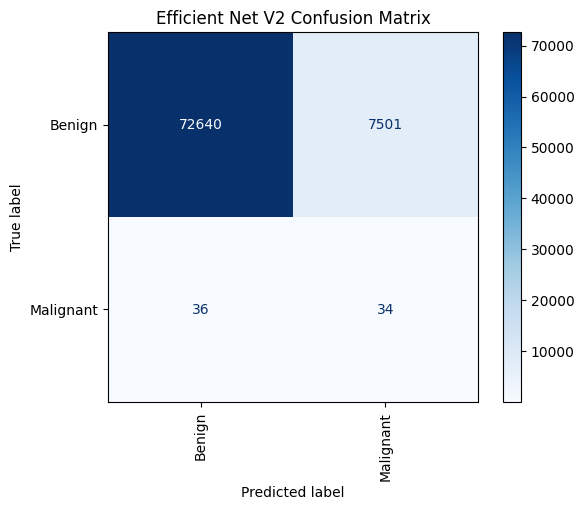

In [ ]:
# Set >=0.5 to 1, rest to 0
eff_net_y_test_pred = np.where(eff_net_y_test_pred < 0.5, 0, 1)

_create_confusion_matrix(eff_net_y_test_target, eff_net_y_test_pred, "Efficient Net V2 Confusion Matrix")

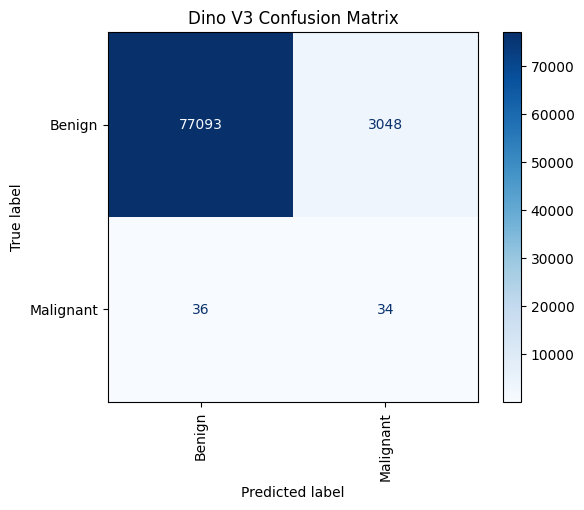

In [ ]:
# Set >=0.5 to 1, rest to 0
dino_test_pred = np.where(dino_test_pred < 0.5, 0, 1)


_create_confusion_matrix(dino_test_target, dino_test_pred, "Dino V3 Confusion Matrix")

### Loss Curves

The data comes from the oututs of the training notebook cells. For the efficient net model, the data is from the last fully completed run.

In [ ]:
def _plot_loss_curve(data: list[tuple], title, xlabel, ylabel):
  """
  Assumes data is in the form [(step, loss), (step, loss), ...]
  """

  df = pl.DataFrame(data, schema=[("step", pl.Int64), ("loss", pl.Float64)], orient="row")

  sns.lineplot(
    x="step",
    y="loss",
    data=df,
    linewidth=2,
    orient="x"
  )

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()


##### Efficient Net Loss Curve

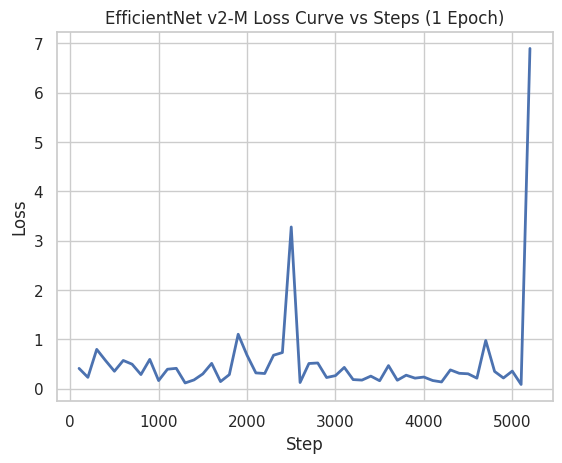

In [ ]:
# Data: List of tuples (step, loss)
data = [
    (100, 0.4121), (200, 0.2303), (300, 0.7978), (400, 0.5703), (500, 0.3542),
    (600, 0.5727), (700, 0.4968), (800, 0.2870), (900, 0.5946), (1000, 0.1645),
    (1100, 0.3951), (1200, 0.4131), (1300, 0.1167), (1400, 0.1780), (1500, 0.3001),
    (1600, 0.5137), (1700, 0.1442), (1800, 0.2861), (1900, 1.1042), (2000, 0.6788),
    (2100, 0.3203), (2200, 0.3083), (2300, 0.6786), (2400, 0.7330), (2500, 3.2796),
    (2600, 0.1256), (2700, 0.5112), (2800, 0.5217), (2900, 0.2267), (3000, 0.2648),
    (3100, 0.4319), (3200, 0.1849), (3300, 0.1746), (3400, 0.2552), (3500, 0.1613),
    (3600, 0.4685), (3700, 0.1714), (3800, 0.2739), (3900, 0.2142), (4000, 0.2366),
    (4100, 0.1659), (4200, 0.1367), (4300, 0.3813), (4400, 0.3124), (4500, 0.3023),
    (4600, 0.2140), (4700, 0.9778), (4800, 0.3501), (4900, 0.2174), (5000, 0.3568),
    (5100, 0.0863), (5200, 6.8996)
]

_plot_loss_curve(data, title='EfficientNet v2-M Loss Curve vs Steps (1 Epoch)', xlabel='Step', ylabel='Loss')

##### Dino Loss Info

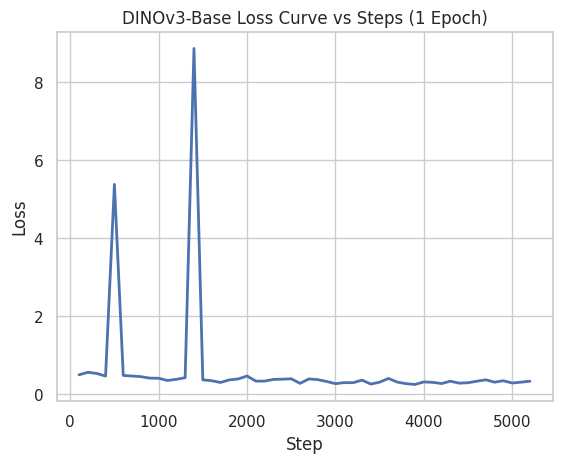

In [ ]:
data = [
    (100, 0.5027), (200, 0.5672), (300, 0.5373), (400, 0.4693), (500, 5.3829),
    (600, 0.4872), (700, 0.4717), (800, 0.4550), (900, 0.4185), (1000, 0.4142),
    (1100, 0.3570), (1200, 0.3877), (1300, 0.4282), (1400, 8.8676), (1500, 0.3732),
    (1600, 0.3522), (1700, 0.3065), (1800, 0.3732), (1900, 0.3965), (2000, 0.4727),
    (2100, 0.3407), (2200, 0.3421), (2300, 0.3847), (2400, 0.3911), (2500, 0.4006),
    (2600, 0.2836), (2700, 0.3968), (2800, 0.3796), (2900, 0.3317), (3000, 0.2762),
    (3100, 0.3027), (3200, 0.3002), (3300, 0.3672), (3400, 0.2660), (3500, 0.3145),
    (3600, 0.4098), (3700, 0.3156), (3800, 0.2762), (3900, 0.2557), (4000, 0.3204),
    (4100, 0.3097), (4200, 0.2790), (4300, 0.3395), (4400, 0.2888), (4500, 0.3002),
    (4600, 0.3388), (4700, 0.3744), (4800, 0.3143), (4900, 0.3501), (5000, 0.2923),
    (5100, 0.3152), (5200, 0.3380)
]

_plot_loss_curve(data, title='DINOv3-Base Loss Curve vs Steps (1 Epoch)', xlabel='Step', ylabel='Loss')

## Push to Hugging Face Hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Push efficient net model

efficient_net_2_model.push_to_hub("avanishd/efficient-net-v2-m-finetuned-skin-lesion-classification")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ication/model.safetensors:  12%|#1        | 24.8MB /  213MB            

CommitInfo(commit_url='https://huggingface.co/avanishd/efficient-net-v2-m-finetuned-skin-lesion-classification/commit/335168b948f16d1247f5e282ef572ec46ec72b47', commit_message='Push model using huggingface_hub.', commit_description='', oid='335168b948f16d1247f5e282ef572ec46ec72b47', pr_url=None, repo_url=RepoUrl('https://huggingface.co/avanishd/efficient-net-v2-m-finetuned-skin-lesion-classification', endpoint='https://huggingface.co', repo_type='model', repo_id='avanishd/efficient-net-v2-m-finetuned-skin-lesion-classification'), pr_revision=None, pr_num=None)

## Check number of parameters for models

In [ ]:
eff_net_num_params = sum(p.numel() for p in efficient_net_2_model.parameters())

print(eff_net_num_params)

52859637


In [ ]:
dino_num_params = sum(p.numel() for p in dino_v3_model.parameters())

print(dino_num_params)

85641985


## Dataset Lengths

In [ ]:
print(len(real_images_dataset))
print(len(synthetic_images_dataset))

401059
15228


In [ ]:
print(len(train_dataset))
print(len(test_dataset))

336076
80211


## Create Model Based on pth for dino

In [ ]:
new_dino_model = DinoSkinLesionClassifier()

state_dict = torch.load("dino_v3_model.pth")
new_dino_model.load_state_dict(state_dict)

new_dino_model.eval()

DinoMelanomaClassifier(
  (backbone): Eva(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (rope): RotaryEmbeddingDinoV3()
    (norm_pre): Identity()
    (blocks): ModuleList(
      (0-11): 12 x EvaBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): EvaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): 

In [ ]:
from safetensors.torch import save_file
import json

metadata = {
  "architecture": "vit_base_patch16_dinov3",
  "base_model": "timm/vit_base_patch16_dinov3",
  "num_classes": 1,
  "task": "image_classification",
  "library_name": "timm",
  "input_type": "image",
  "input_size": [3, 224, 224],
  }

with open("config.json", "w") as f:
    json.dump(metadata, f, indent=4)

save_file(new_dino_model.state_dict(), "dino_v3_model.safetensors")

In [ ]:
from huggingface_hub import HfApi

repo_id = "avanishd/vit-base-patch16-dinov3-finetuned-skin-lesion-classification"

api = HfApi()
# api.create_repo(repo_id=repo_id, repo_type="model") # Uncomment to create repo if it doesn't exist

api.upload_file(
    path_or_fileobj="dino_v3_model.safetensors",
    path_in_repo="model.safetensors",
    repo_id=repo_id,
    repo_type="model",
)

api.upload_file(
    path_or_fileobj="config.json",
    path_in_repo="config.json",
    repo_id=repo_id,
    repo_type="model",
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  dino_v3_model.safetensors   :  14%|#4        | 48.9MB /  343MB            

CommitInfo(commit_url='https://huggingface.co/avanishd/vit-base-patch16-dinov3-finetuned-skin-lesion-classification/commit/32d3642e7d41142bc8c992714a0e3f50ae2523ce', commit_message='Upload config.json with huggingface_hub', commit_description='', oid='32d3642e7d41142bc8c992714a0e3f50ae2523ce', pr_url=None, repo_url=RepoUrl('https://huggingface.co/avanishd/vit-base-patch16-dinov3-finetuned-skin-lesion-classification', endpoint='https://huggingface.co', repo_type='model', repo_id='avanishd/vit-base-patch16-dinov3-finetuned-skin-lesion-classification'), pr_revision=None, pr_num=None)